In [4]:
import torch
import matplotlib.pyplot as plt
from coding_scheme_base_functions import (Sigma_ab_cd, EncoderApprox1D, ZigZagMemorizer, PLCSMMemorizer,  CodingScheme1D, EncoderSupApprox1D, EncoderExact1D)

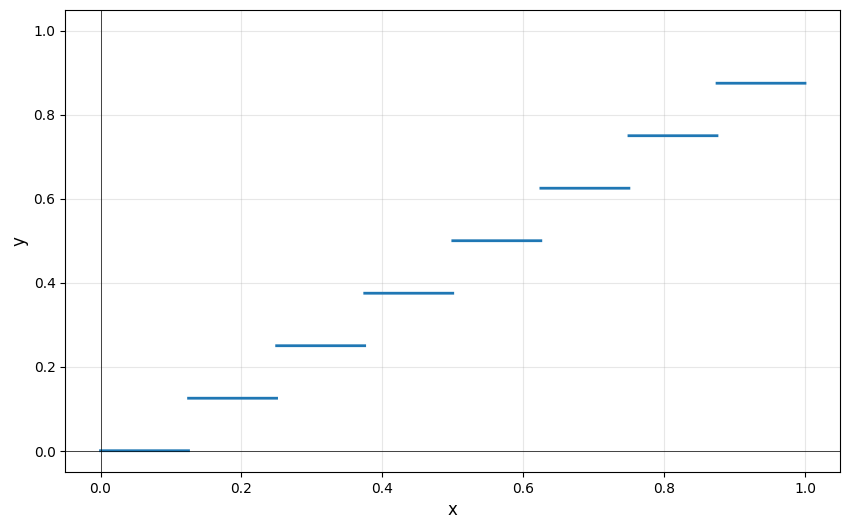

In [6]:
encoder_exact = EncoderExact1D(K=3)
encoder_exact.plot(show_title=False)

In [3]:
dtype = torch.float64
device = "cpu"

In [ ]:
def squared_shifted(x):
    return -3 * (x - 0.5) ** 2 + 0.75

def gaussian_mixture_with_step(x):
    return 0.6 * torch.exp(-50 * (x - 0.3) ** 2) + 0.6 * torch.exp(-30 * (x - 0.7) ** 2) + 0.35 * (x > 0.55).double()

def swish_shifted(x):
    return 3 * (x - 0.7) * torch.sigmoid(3 * (x - 0.7)) + 0.3

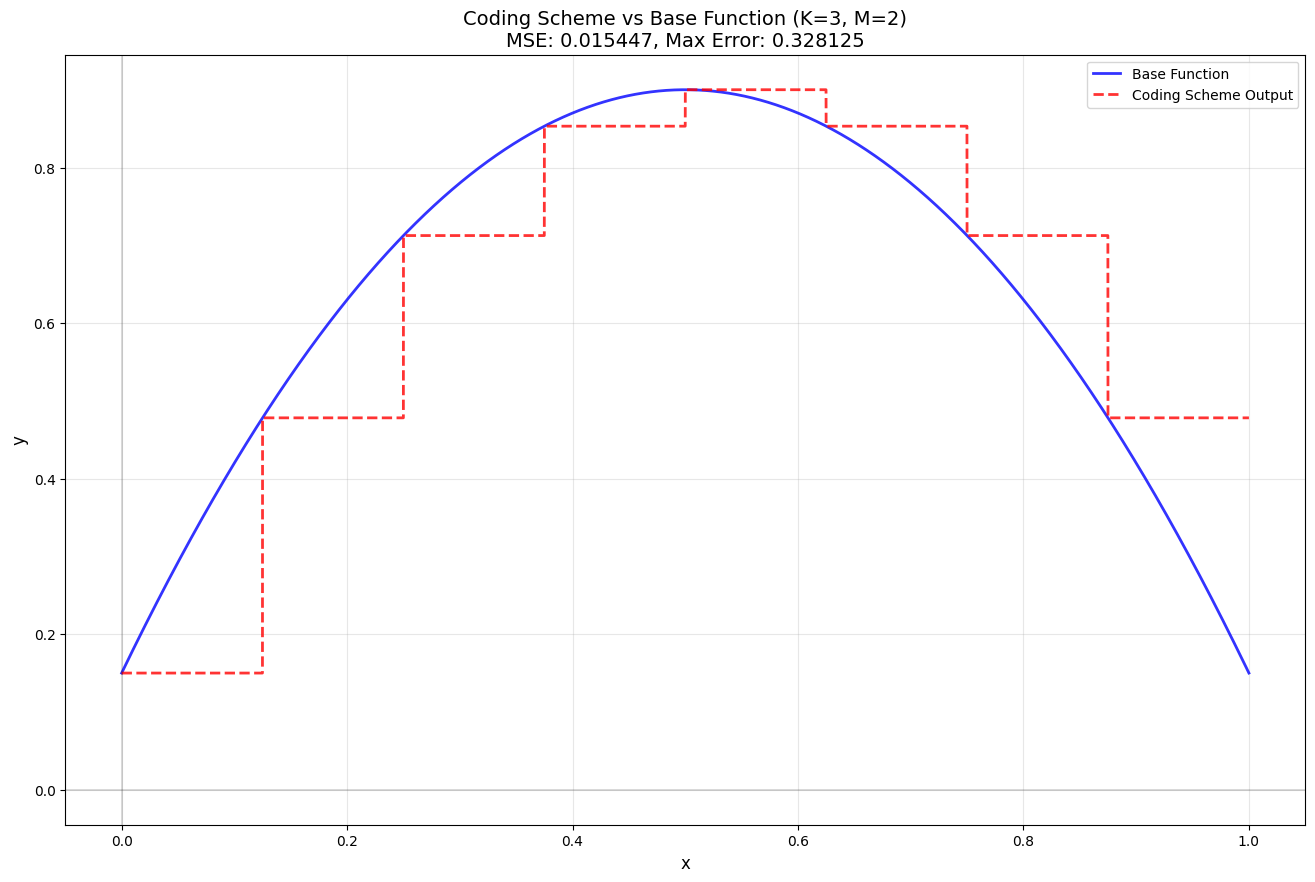

In [ ]:
coding_scheme_sup_squared = CodingScheme1D(squared_shifted, K=3, flat_slope=1e-12, dtype=dtype, device=device, scheme_type="sup")
coding_scheme_sup_squared.plot_with_base_function()

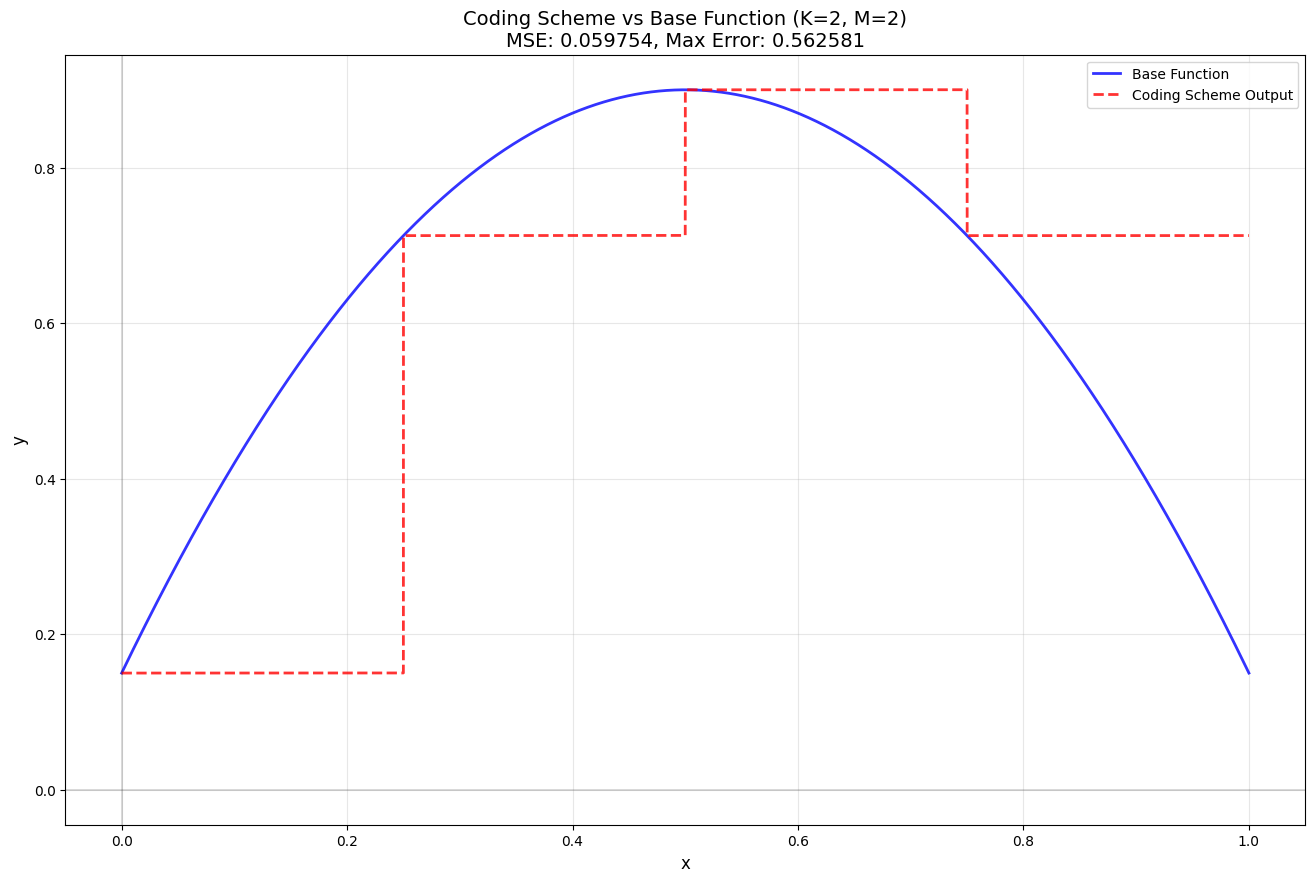

For Squared Shifted Function with Sup Approximation with parameters K=2, M=2, gamma=0.0001, flat_slope=0.0001:
 - L2 error: 0.244446, Max error: 0.562581


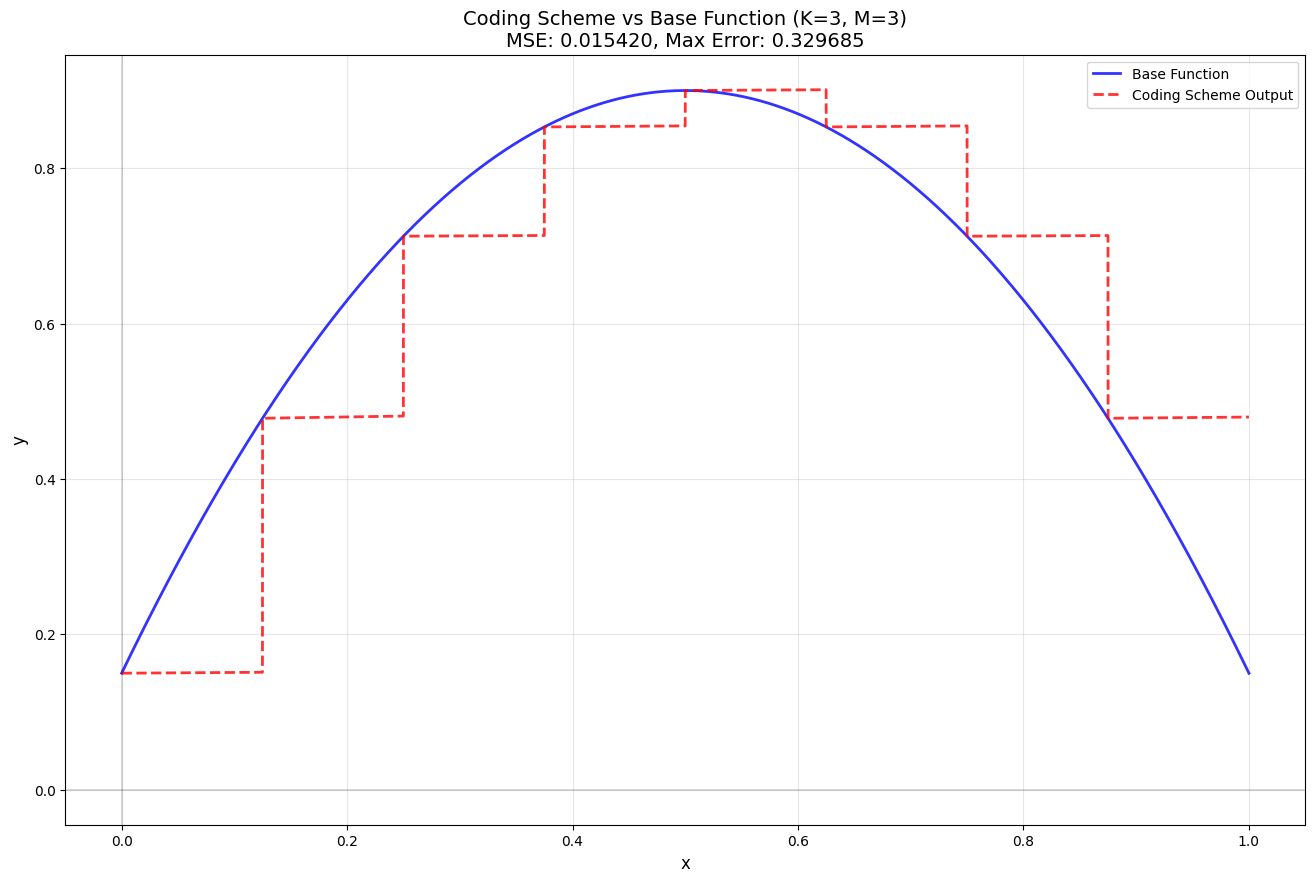

For Squared Shifted Function with Sup Approximation with parameters K=3, M=3, gamma=0.01, flat_slope=0.001:
 - L2 error: 0.124177, Max error: 0.329685


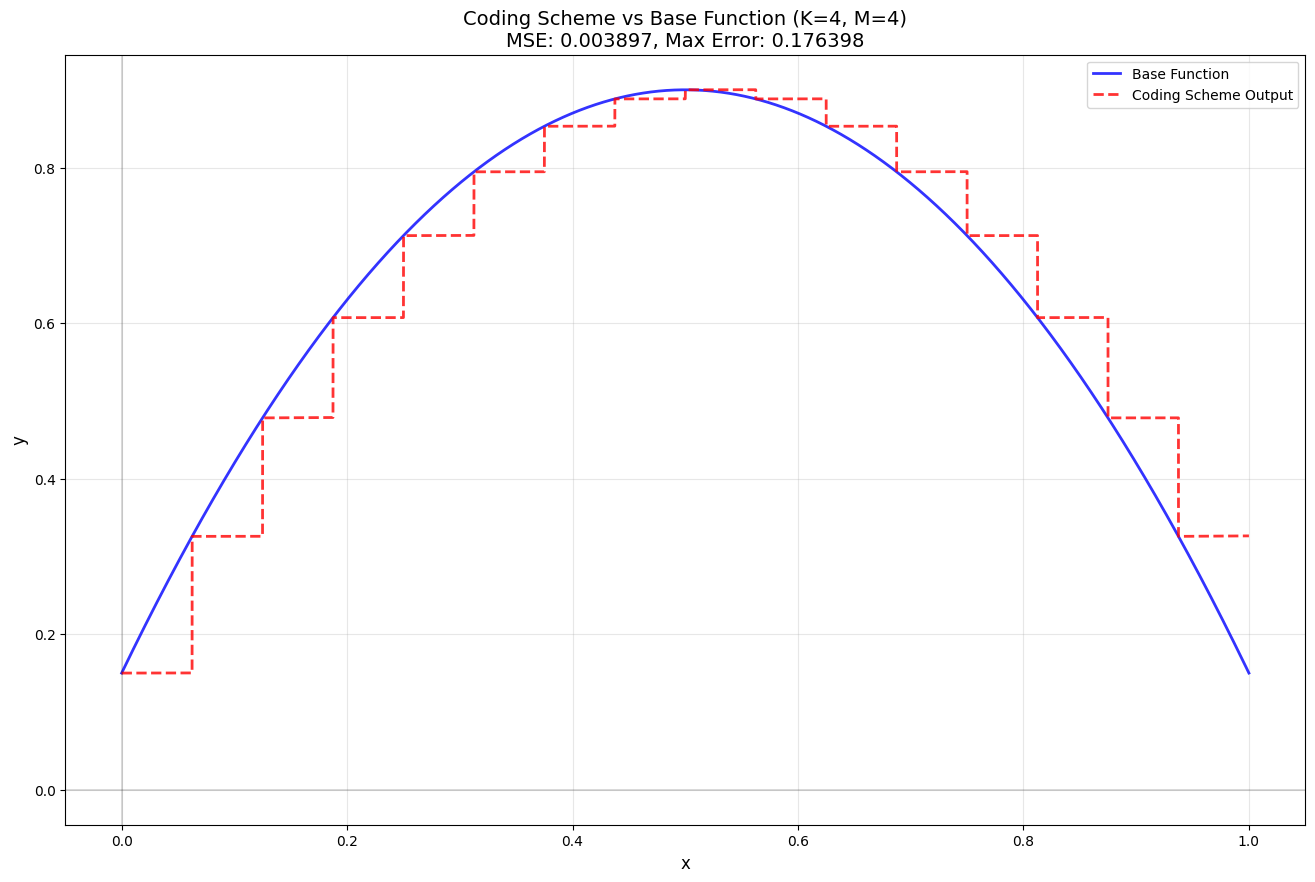

For Squared Shifted Function with Sup Approximation with parameters K=4, M=4, gamma=0.001, flat_slope=0.0001:
 - L2 error: 0.062425, Max error: 0.176398


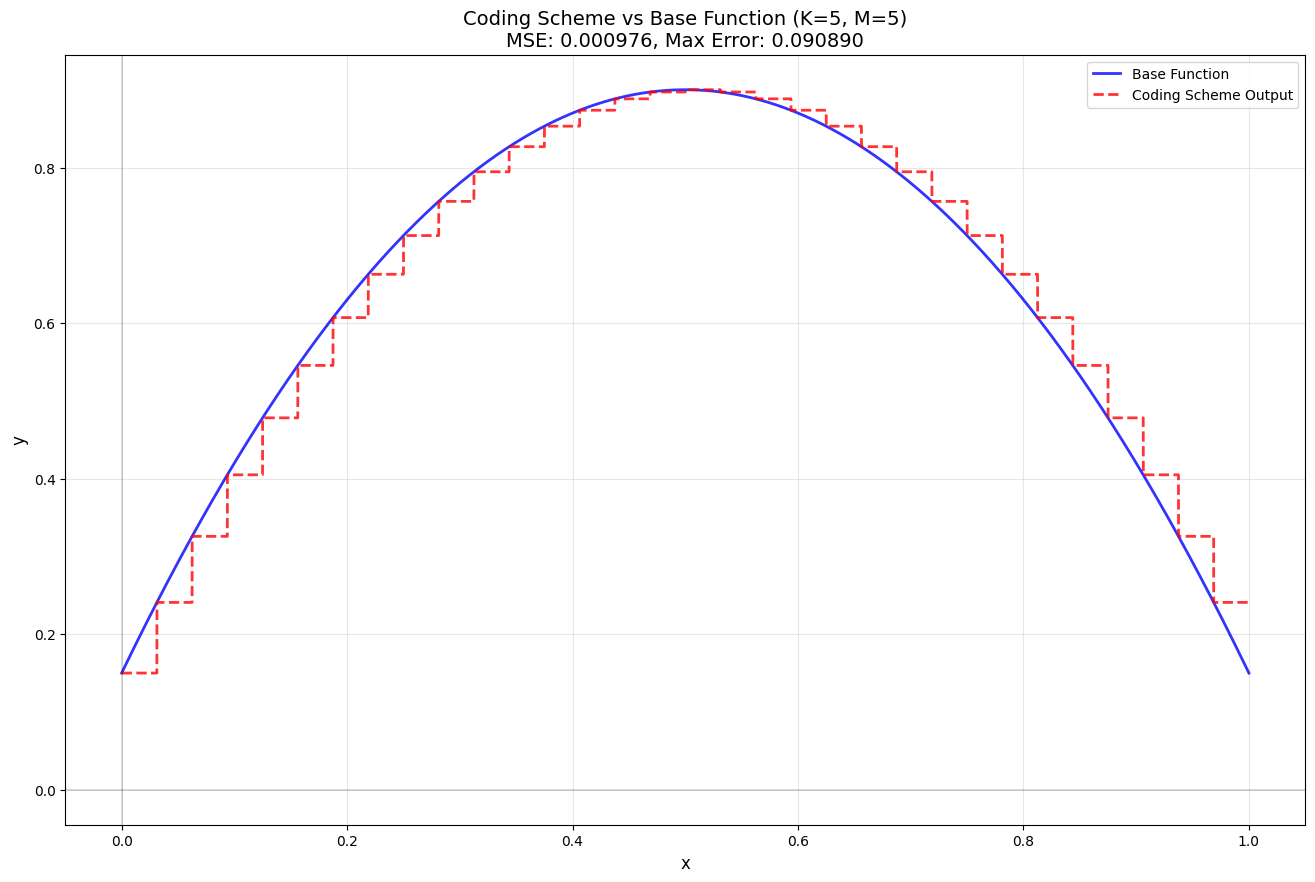

For Squared Shifted Function with Sup Approximation with parameters K=5, M=5, gamma=0.0001, flat_slope=1e-05:
 - L2 error: 0.031244, Max error: 0.090890


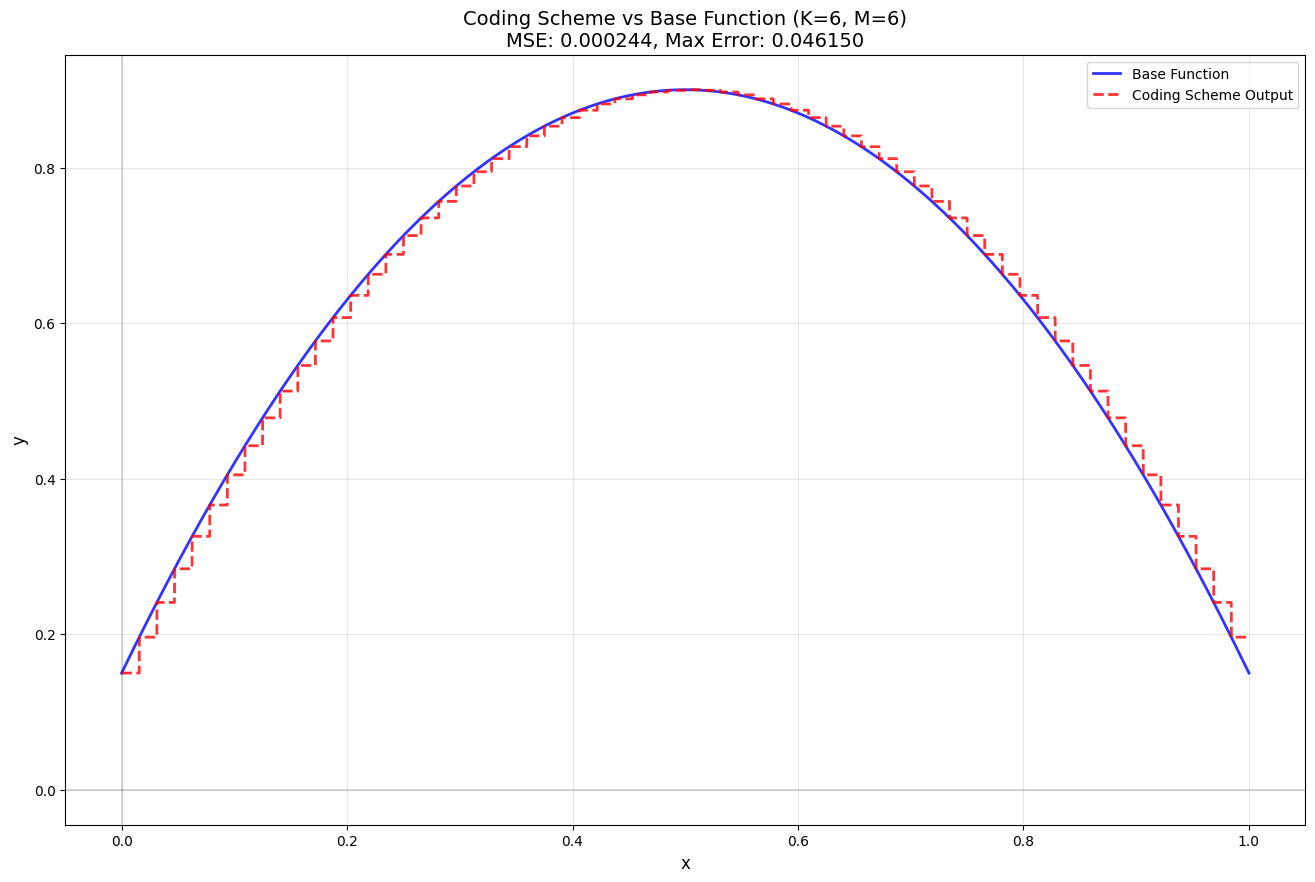

For Squared Shifted Function with Sup Approximation with parameters K=6, M=6, gamma=1e-06, flat_slope=1e-06:
 - L2 error: 0.015626, Max error: 0.046150


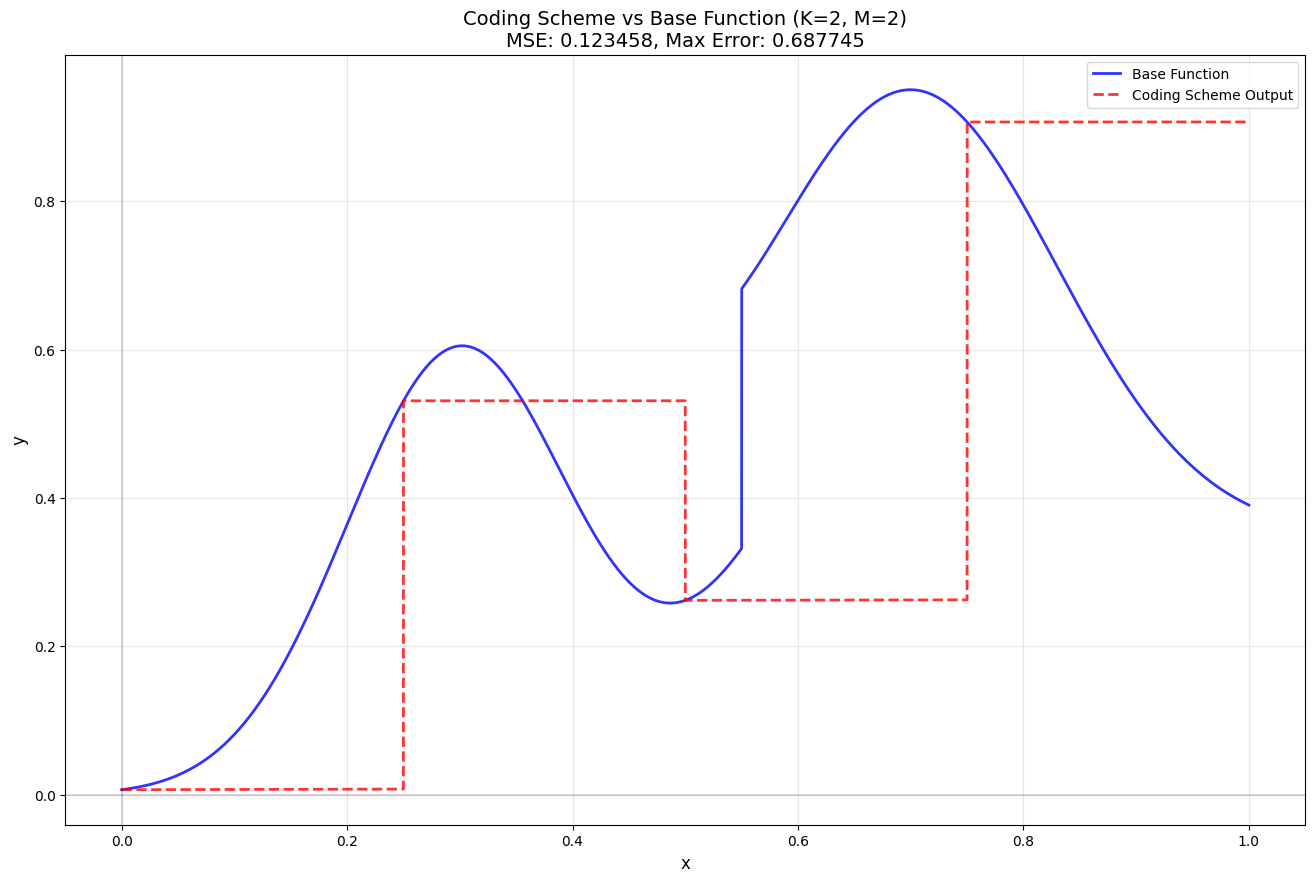

For Gaussian Mixture with Step Function with Sup Approximation with parameters K=2, M=2, gamma=0.0001, flat_slope=0.0001:
 - L2 error: 0.351367, Max error: 0.687745


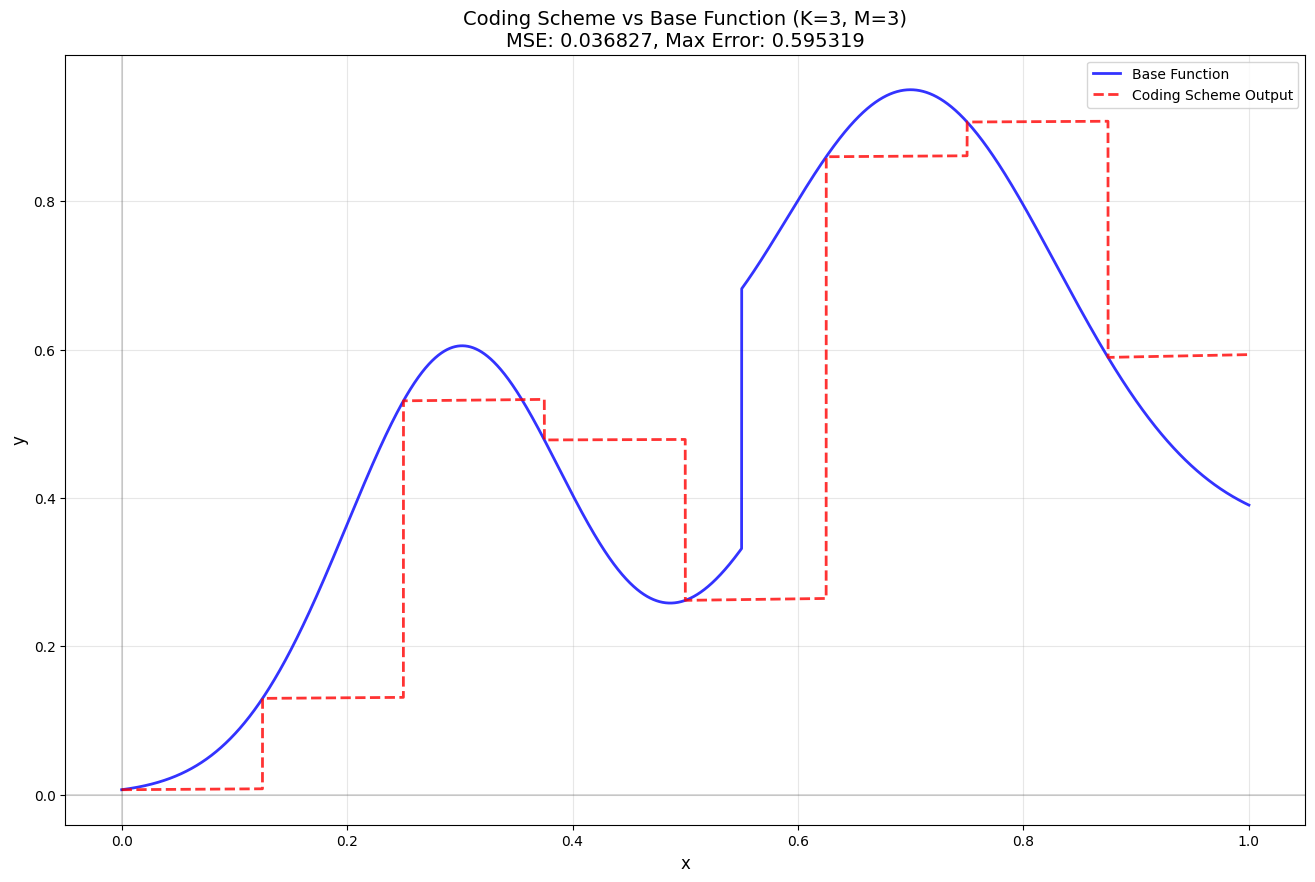

For Gaussian Mixture with Step Function with Sup Approximation with parameters K=3, M=3, gamma=0.01, flat_slope=0.001:
 - L2 error: 0.191904, Max error: 0.595319


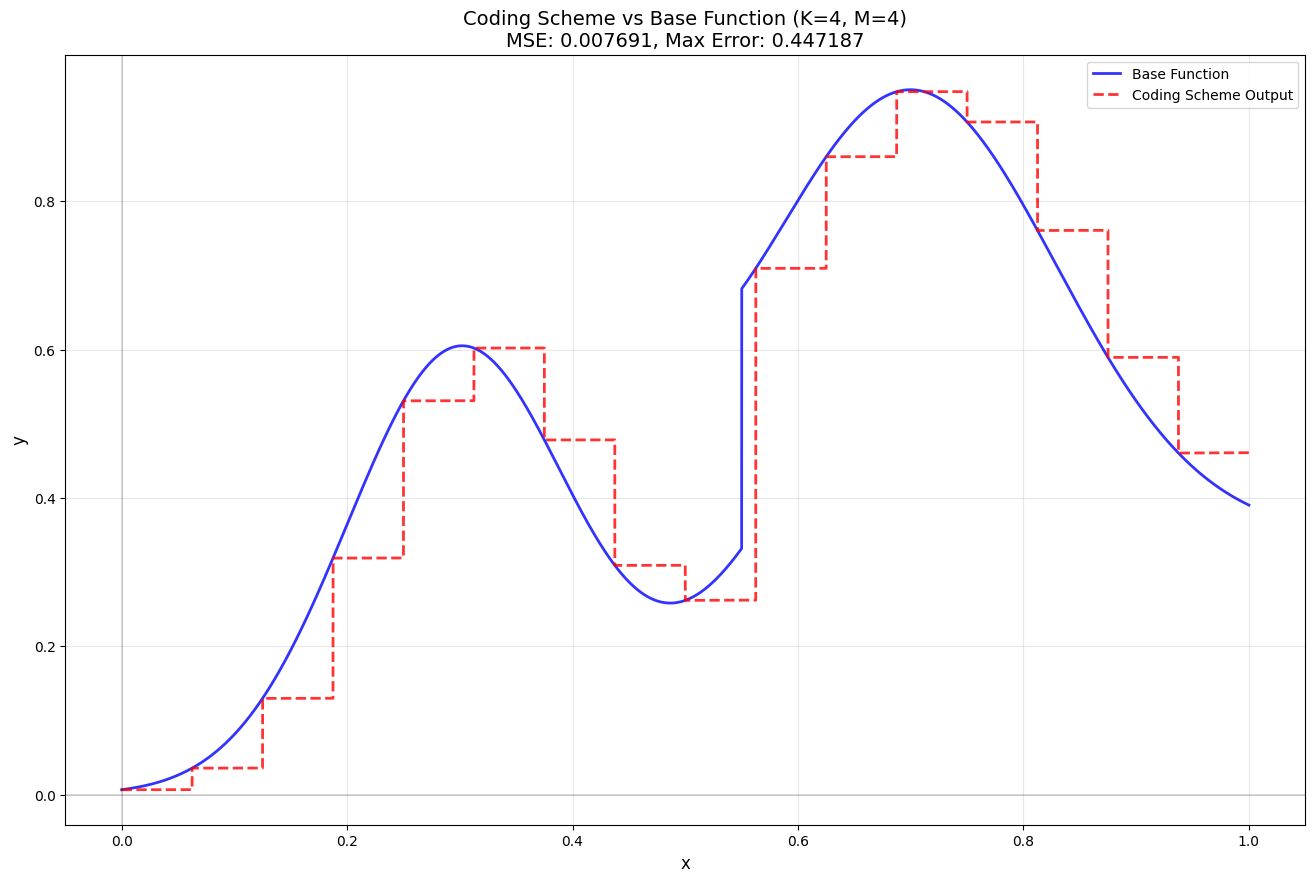

For Gaussian Mixture with Step Function with Sup Approximation with parameters K=4, M=4, gamma=0.001, flat_slope=0.0001:
 - L2 error: 0.087697, Max error: 0.447106


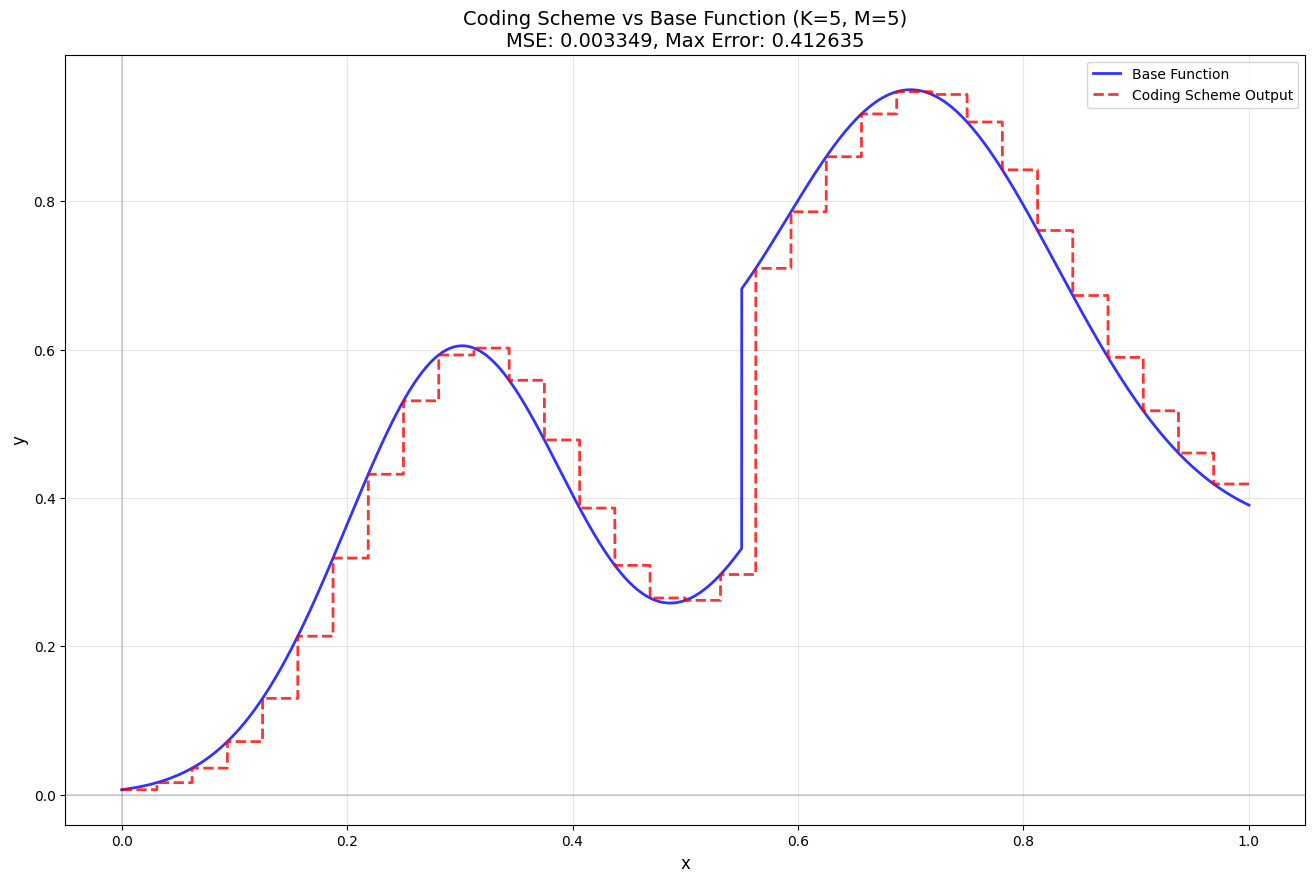

For Gaussian Mixture with Step Function with Sup Approximation with parameters K=5, M=5, gamma=0.0001, flat_slope=1e-05:
 - L2 error: 0.057873, Max error: 0.412554


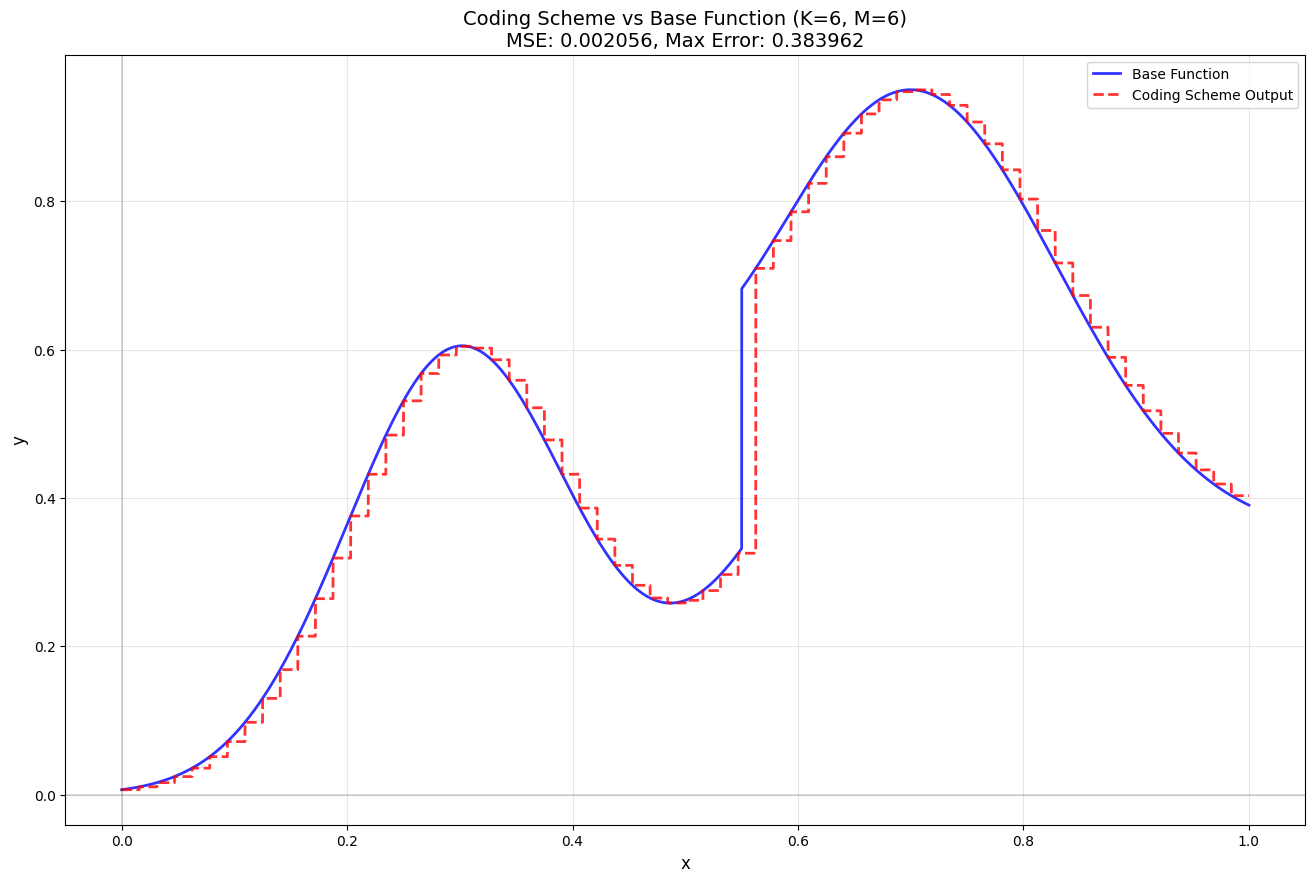

For Gaussian Mixture with Step Function with Sup Approximation with parameters K=6, M=6, gamma=1e-06, flat_slope=1e-06:
 - L2 error: 0.045348, Max error: 0.383881


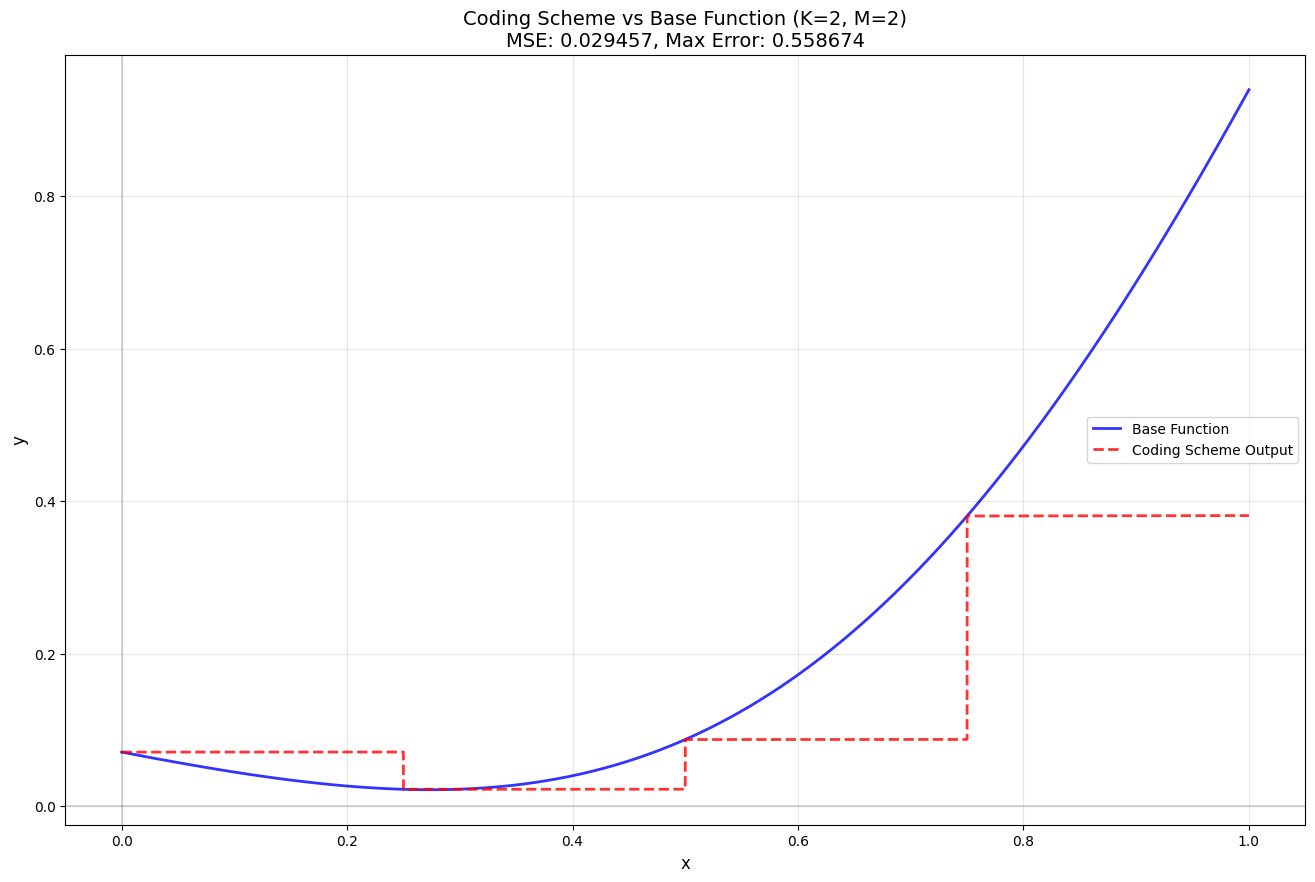

For Swish Shifted Function with Sup Approximation with parameters K=2, M=2, gamma=0.0001, flat_slope=0.0001:
 - L2 error: 0.171630, Max error: 0.558674


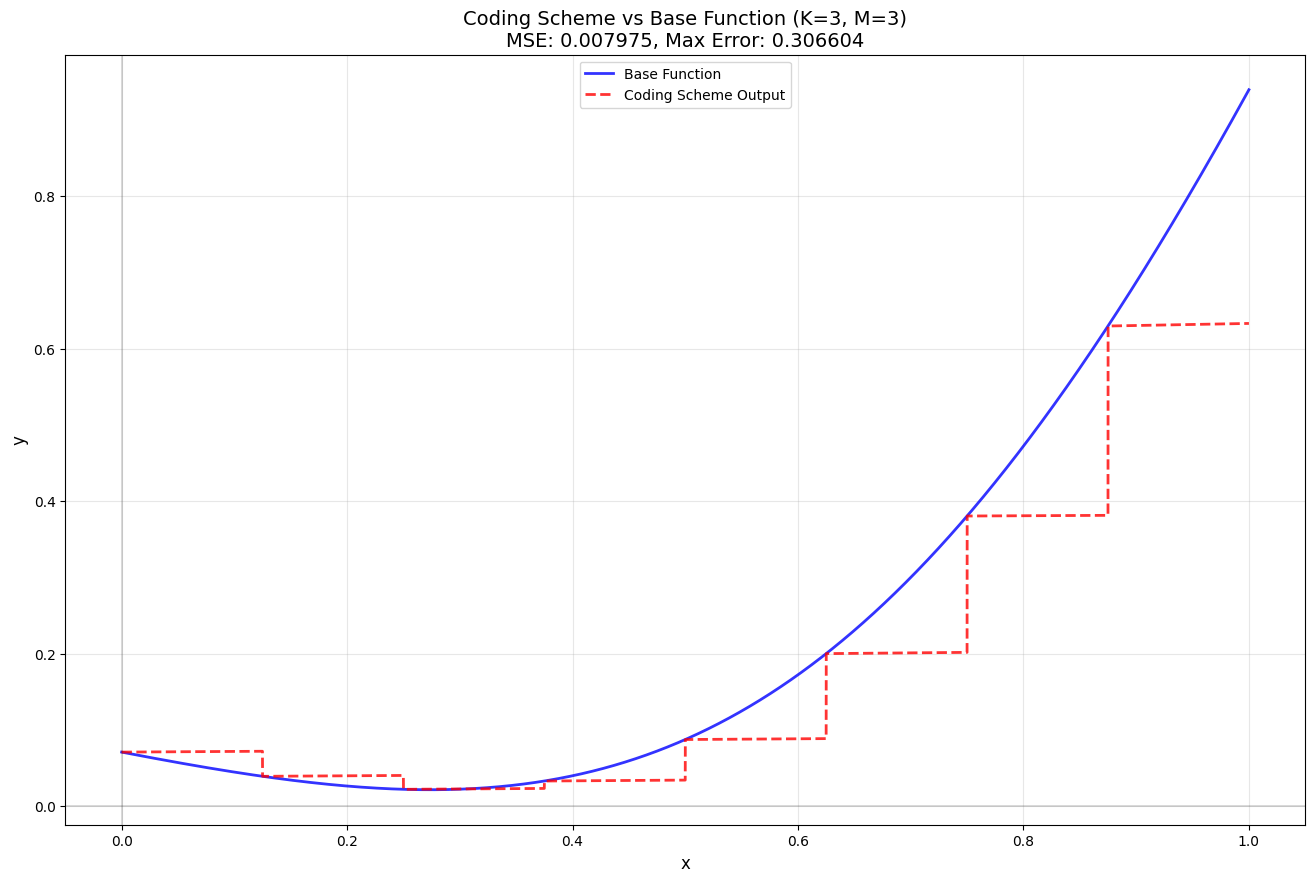

For Swish Shifted Function with Sup Approximation with parameters K=3, M=3, gamma=0.01, flat_slope=0.001:
 - L2 error: 0.089302, Max error: 0.306604


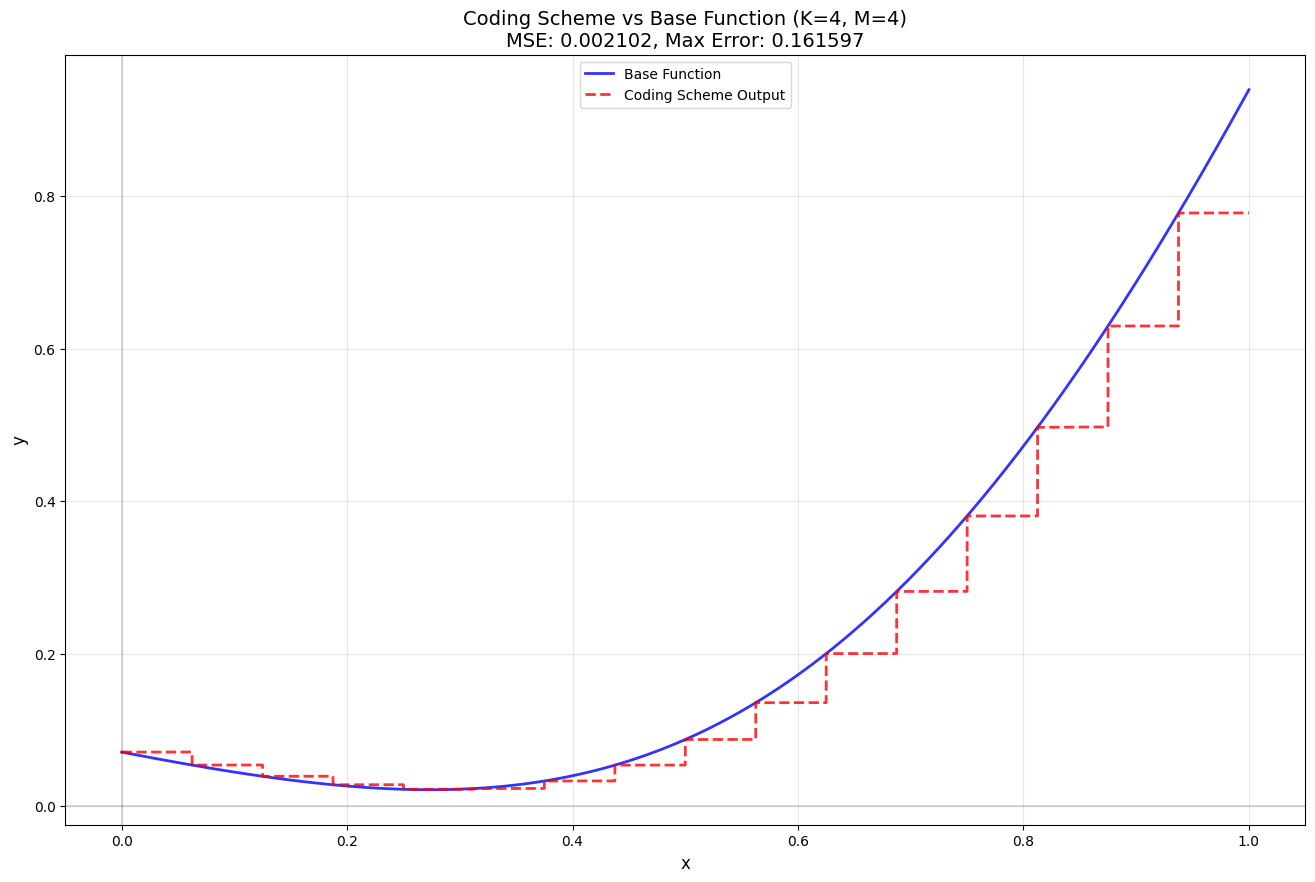

For Swish Shifted Function with Sup Approximation with parameters K=4, M=4, gamma=0.001, flat_slope=0.0001:
 - L2 error: 0.045882, Max error: 0.161597


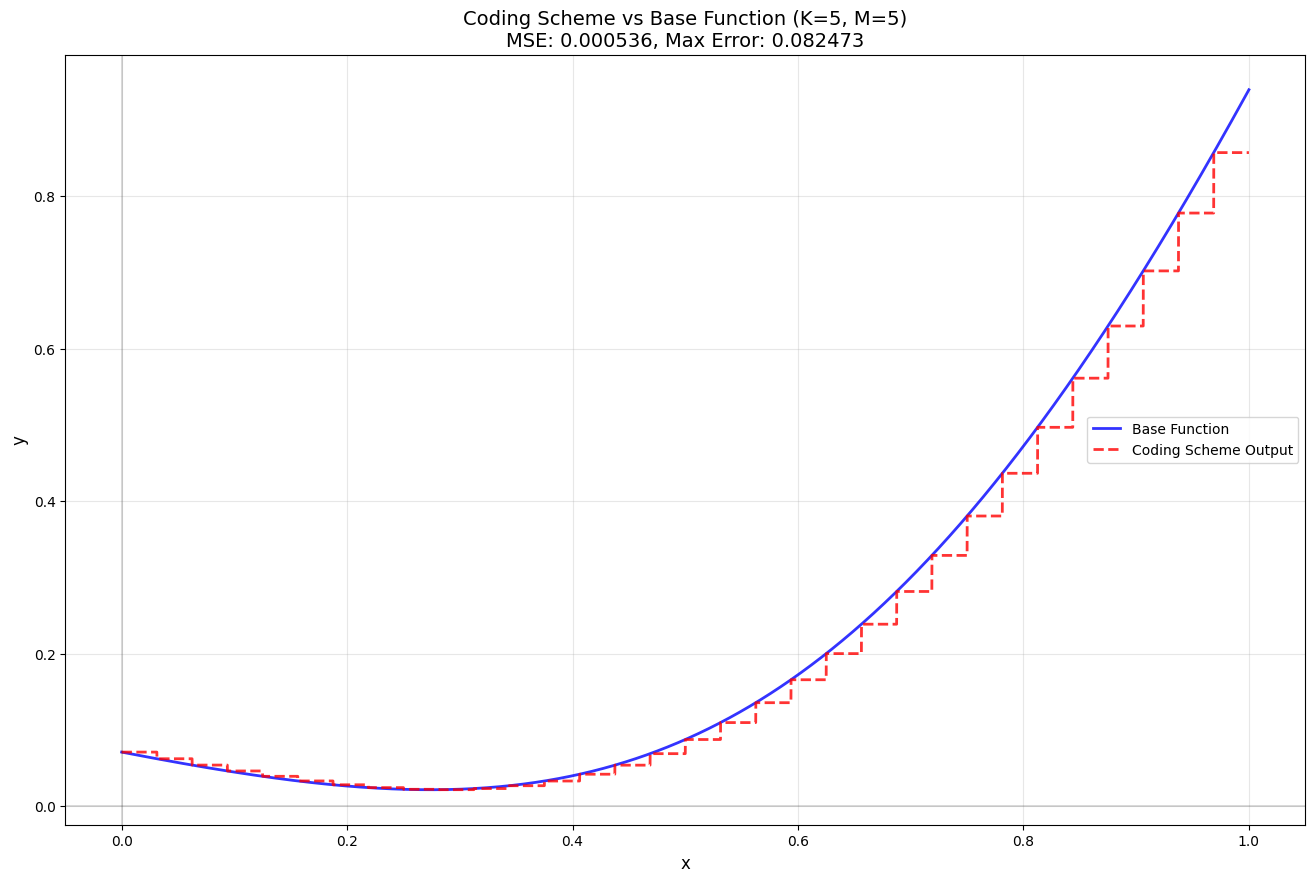

For Swish Shifted Function with Sup Approximation with parameters K=5, M=5, gamma=0.0001, flat_slope=1e-05:
 - L2 error: 0.023172, Max error: 0.082473


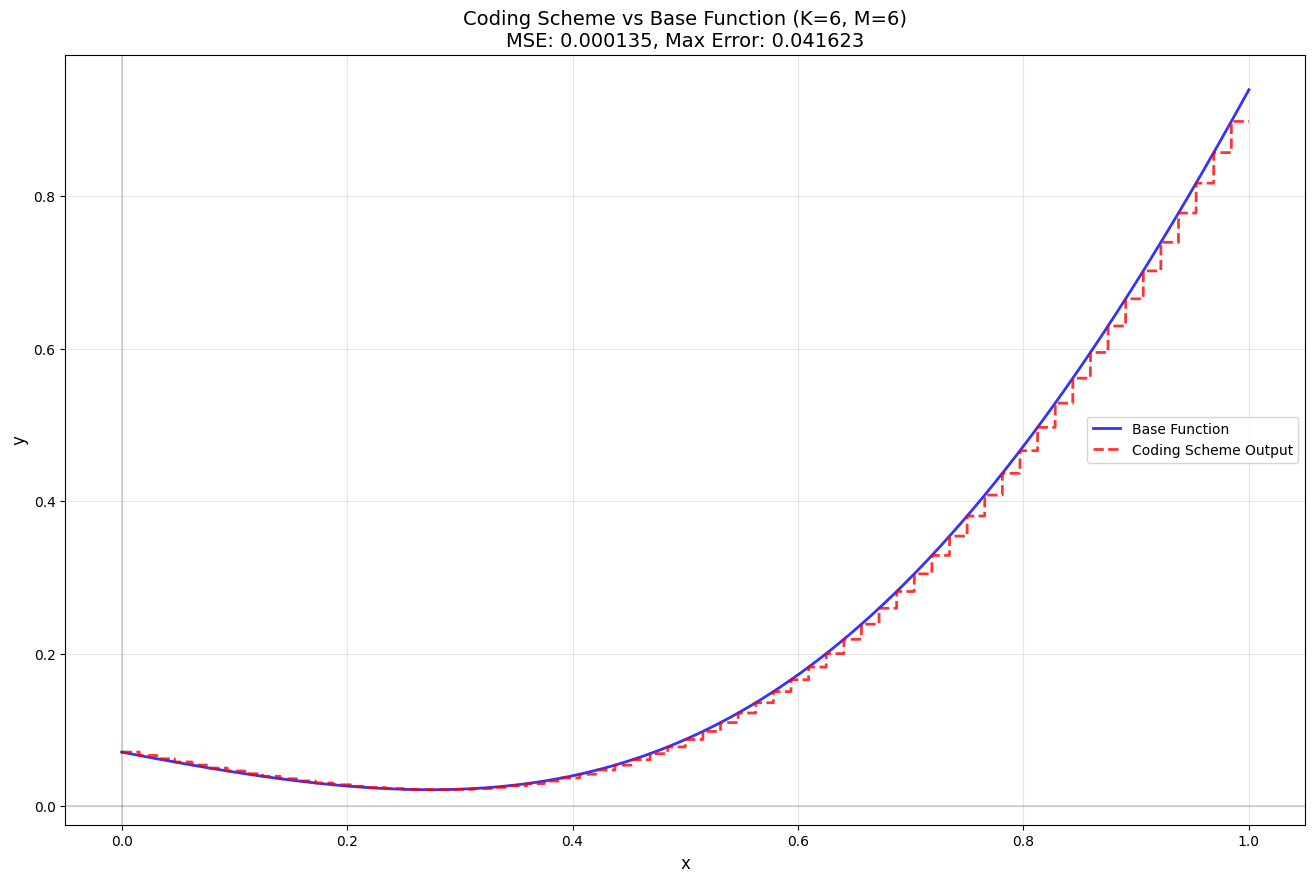

For Swish Shifted Function with Sup Approximation with parameters K=6, M=6, gamma=1e-06, flat_slope=1e-06:
 - L2 error: 0.011636, Max error: 0.041623


[(2, 2, 0.0001, 0.0001, 0.17163000669523232, 0.5586737802254462),
 (3, 3, 0.01, 0.001, 0.08930209990199316, 0.30660447121125967),
 (4, 4, 0.001, 0.0001, 0.04588184626211127, 0.1615973808382949),
 (5, 5, 0.0001, 1e-05, 0.02317181956088604, 0.08247296385546521),
 (6, 6, 1e-06, 1e-06, 0.011636080637195862, 0.04162327553318157)]

In [ ]:
input_params = [(2,2,1e-4,1e-4), (3,3,0.01,1e-3), (4,4,0.001,1e-4), (5,5,0.0001,1e-5), (6,6,1e-6,1e-6)]
coding_scheme_sup_squared = CodingScheme1D(squared_shifted, dtype=dtype, device=device, scheme_type="sup")
coding_scheme_sup_squared.evaluate_for_list_of_parameters(input_params, "Squared Shifted Function with Sup Approximation", plot=True)
coding_scheme_sup_gaussian = CodingScheme1D(gaussian_mixture_with_step, dtype=dtype, device=device, scheme_type="sup")
coding_scheme_sup_gaussian.evaluate_for_list_of_parameters(input_params, "Gaussian Mixture with Step Function with Sup Approximation", plot=True)
coding_scheme_sup_swish = CodingScheme1D(swish_shifted, dtype=dtype, device=device, scheme_type="sup")
coding_scheme_sup_swish.evaluate_for_list_of_parameters(input_params, "Swish Shifted Function with Sup Approximation", plot=True)